In [1156]:
import matplotlib.pyplot as plt 
import pandas as pd
import math
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import GRU 
from keras.layers import Merge
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import Conv2D, GlobalMaxPooling2D

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MaxAbsScaler

import psycopg2
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt 
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'
import seaborn as sns

import keras_functions
from keras_functions import *

In [1333]:
binvars = get_categorical_variables([
    'all_participanttypes',
    'all_language'
])

In [1334]:
tags = get_categorical_variables(['all_tags'])

# Initial pipeline

In [501]:
with open('set_train.txt') as f:
    train_handles = [h.strip() for h in f.readlines()]
with open('set_test.txt') as f:
    test_handles = [h.strip() for h in f.readlines()]
with open('set_val.txt') as f:
    val_handles = [h.strip() for h in f.readlines()]

In [1335]:
# user columns can be out of order, use tourist's as correct order
with open('rnn_train/tourist.csv') as f:
    correct_cols = [t.strip() for t in f.readline().split(',')]

In [1336]:
correct_cols = [c for c in correct_cols if c not in tags]

In [1445]:
from os.path import exists
reload(keras_functions)
maxtimepts = 200

th = [ "abyssmall", "razia_sultana", "ufo", "williamhu08", "rdfz_yjy", "k21", "rudradevbasak", "ch_egor", "FreeMoneyCity", "Gomhog", "Life_is_like_a_boat", "MikhailRubinchik", "Oleg_Smirnov", "jiangshibiao", "Dembel", "Logic_zys", "Shayan_Jahan", "dc.", "wakaka", "chnluyi", "Koreyoshi_", "vlecomte", "AleksanderBalobanov", "Gerald", "hex539", "lovro", "MKLOL", "RNS", "gskhirtladze", "jzzhu", "Ai_AA", "JeBeK", "MHR", "alex256", "darknstd", "dragoon", "feyat" ]
X, Y, lens_tr, maxt = keras_functions.get_train_data(th, binvars, correct_cols, maxtimepts)

#Xval, Yval, lens_val, maxt = keras_functions.get_train_data(val_handles[0:10], binvars, correct_cols, maxtimepts)

rnn_train/abyssmall.csv
rnn_train/razia_sultana.csv
rnn_train/ufo.csv
rnn_train/williamhu08.csv
rnn_train/rdfz_yjy.csv
rnn_train/k21.csv
rnn_train/rudradevbasak.csv
rnn_train/ch_egor.csv
rnn_train/FreeMoneyCity.csv
rnn_train/Gomhog.csv
rnn_train/Life_is_like_a_boat.csv
rnn_train/MikhailRubinchik.csv
rnn_train/Oleg_Smirnov.csv
rnn_train/jiangshibiao.csv


ValueError: negative dimensions are not allowed

In [1443]:
binvars

['PRACTICE',
 'OUT_OF_COMPETITION',
 'GYM',
 'VIRTUAL',
 'CONTESTANT',
 'Java 6',
 'Mysterious Language',
 'GNU C++14',
 'FALSE',
 'Haskell',
 'Delphi',
 'GNU C',
 'Python 3',
 'Factor',
 'Picat',
 'MS C++',
 'Secret_171',
 'PHP',
 'Tcl',
 'Java 8',
 'Scala',
 'Io',
 'Python 2',
 'GNU C++',
 'FPC',
 'J',
 'Rust',
 'PyPy 2',
 'JavaScript',
 'GNU C++0x',
 'MS C#',
 'Ada',
 'Go',
 'GNU C11',
 'Cobol',
 'Befunge',
 'Roco',
 'Ruby',
 'Kotlin',
 'GNU C++11 ZIP',
 'F#',
 'GNU C++11',
 'Perl',
 'Pike',
 'Java 8 ZIP',
 'D',
 'Ocaml',
 'PyPy 3',
 'Mono C#',
 'Java 7']

In [1381]:
reload(keras_functions)
maxtimepts = 200
X, Y, lens_tr, maxt, colnames = keras_functions.get_train_data(['sanket407'], binvars, correct_cols, maxtimepts) #jiyutian

rnn_train/sanket407.csv


In [1444]:
xmax

array([  5.00000000e+00,   2.18610083e+03,   2.29850056e+03,
         4.29719444e+02,   5.00000000e+03,   3.00000000e+03,
         5.00000000e+03,   3.42700000e+03,   5.00000000e+03,
         2.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   8.00000000e+00,   1.60000000e+01,
         1.00000000e+00])

In [1382]:
maxt

31

In [525]:
th2 = [ "123qws", "613", "Alona", "AstroConjecture", "chipchip3412", "hmich   ", "mstczuo", "pandazcy", "Fefer_Ivan", "edward_mj", "jerjeriscute", "-Wave-", "Constantius", "I_dont_have_girlfriend", "SealView", "antonkov" ]
Xval, Yval, lens_val, maxt = keras_functions.get_train_data(th2, binvars, correct_cols, maxtimepts)

rnn_train/123qws.csv
rnn_train/613.csv
rnn_train/Alona.csv
rnn_train/AstroConjecture.csv
rnn_train/chipchip3412.csv
rnn_train/hmich   .csv
rnn_train/mstczuo.csv
rnn_train/pandazcy.csv
rnn_train/Fefer_Ivan.csv
rnn_train/edward_mj.csv
rnn_train/jerjeriscute.csv
rnn_train/-Wave-.csv
rnn_train/Constantius.csv
rnn_train/I_dont_have_girlfriend.csv
rnn_train/SealView.csv
rnn_train/antonkov.csv


In [926]:
maxt

46

# Scaling
RATING MUST BE ON THE SAME SCALE


In [1383]:
Xflat = np.concatenate(X)
print Xflat.shape
Xflat = np.reshape(Xflat, [Xflat.shape[0]*Xflat.shape[1], Xflat.shape[2]])
print Xflat.shape
#scaler = MaxAbsScaler().fit(Xflat)

(28, 200, 16)
(5600, 16)


In [1402]:
xmax = np.max(Xflat, axis=0)
xmax[xmax == 0] = 1
xmax[colnames.index('smoothed_3months')]
xmax[colnames.index('problem_rating')]

5000.0

In [1405]:
month = 3
colnames_rate = ['smoothed_%dmonths'%month, 'oldrating', 'problem_rating']
maxrating = 5000.0
idx_rate = [colnames.index(c) for c in colnames_rate]
xmax[idx_rate] = maxrating

# Define model

In [1436]:
reload(keras_functions)
batchsize = X[0].shape
gru1 = 6
gru2 = 3
dense = 50
model = keras_functions.create_model([gru1, gru2, dense], batchsize)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_134 (Masking)        (28, 200, 16)             0         
_________________________________________________________________
gru_241 (GRU)                (28, 200, 6)              396       
_________________________________________________________________
gru_242 (GRU)                (28, 3)                   81        
_________________________________________________________________
dense_235 (Dense)            (28, 50)                  150       
_________________________________________________________________
dropout_144 (Dropout)        (28, 50)                  0         
_________________________________________________________________
dense_236 (Dense)            (28, 1)                   50        
Total params: 677
Trainable params: 677
Non-trainable params: 0
_________________________________________________________________


In [1440]:
optimizer = keras.optimizers.RMSprop(lr=0.01, decay=0.05)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mae'])

In [1438]:
history = []
epochs = 100
ymax = 300.0

xin = X[0]/xmax
yin = Y[0]/ymax

for i in range(epochs):
    h = model.fit(xin, yin, epochs=1, shuffle=False, batch_size=batchsize[0], verbose=1)
    model.reset_states()
    history.append(h)

Epoch 1/1
28/28 [==============================] - 10s - loss: 0.0260 - mean_absolute_error: 0.1239
Epoch 1/1
28/28 [==============================] - 0s - loss: 0.0600 - mean_absolute_error: 0.1853
Epoch 1/1
28/28 [==============================] - 0s - loss: 0.0142 - mean_absolute_error: 0.0903
Epoch 1/1
28/28 [==============================] - 0s - loss: 0.0178 - mean_absolute_error: 0.1068
Epoch 1/1
28/28 [==============================] - 0s - loss: 0.0096 - mean_absolute_error: 0.0761
Epoch 1/1
28/28 [==============================] - 0s - loss: 0.0130 - mean_absolute_error: 0.0848
Epoch 1/1
28/28 [==============================] - 1s - loss: 0.0133 - mean_absolute_error: 0.0950
Epoch 1/1
28/28 [==============================] - 0s - loss: 0.0105 - mean_absolute_error: 0.0826
Epoch 1/1
28/28 [==============================] - 0s - loss: 0.0098 - mean_absolute_error: 0.0757
Epoch 1/1
28/28 [==============================] - 0s - loss: 0.0172 - mean_absolute_error: 0.0857
Epoch 1/1

28/28 [==============================] - 0s - loss: 0.0045 - mean_absolute_error: 0.0528
Epoch 1/1
28/28 [==============================] - 0s - loss: 0.0098 - mean_absolute_error: 0.0735
Epoch 1/1
28/28 [==============================] - 0s - loss: 0.0076 - mean_absolute_error: 0.0698
Epoch 1/1
28/28 [==============================] - 0s - loss: 0.0081 - mean_absolute_error: 0.0731
Epoch 1/1
28/28 [==============================] - 0s - loss: 0.0088 - mean_absolute_error: 0.0743
Epoch 1/1
28/28 [==============================] - 0s - loss: 0.0062 - mean_absolute_error: 0.0572
Epoch 1/1
28/28 [==============================] - 0s - loss: 0.0072 - mean_absolute_error: 0.0685
Epoch 1/1
28/28 [==============================] - 0s - loss: 0.0178 - mean_absolute_error: 0.0867
Epoch 1/1
28/28 [==============================] - 0s - loss: 0.0088 - mean_absolute_error: 0.0770
Epoch 1/1
28/28 [==============================] - 0s - loss: 0.0073 - mean_absolute_error: 0.0709
Epoch 1/1
28/28 [===

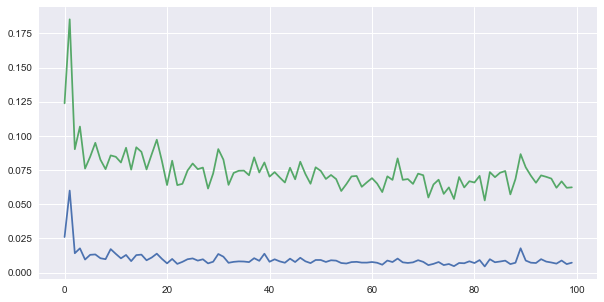

In [1441]:
plt.rcParams['figure.figsize'] = (10, 5)
loss = np.concatenate([h.history['loss'] for h in history])
mae = np.concatenate([h.history['mean_absolute_error'] for h in history])
#loss = history.history['loss']
#mae = history.history['mean_absolute_error']
plt.plot(loss)
plt.plot(mae)

0.2073123730514338

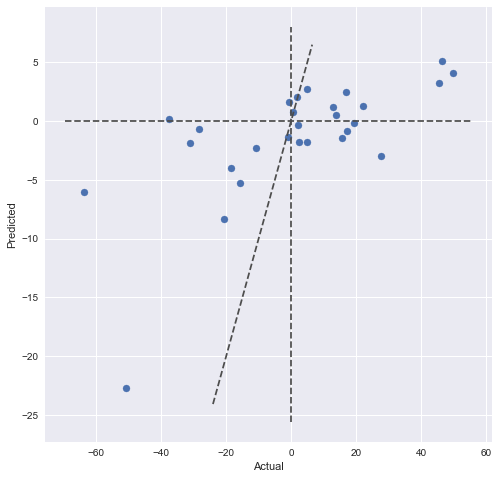

In [1442]:
model.reset_states()
#y_pred = model.predict([xwide, xin], batch_size=X[0].shape[0])
y_pred = model.predict(xin, batch_size=X[0].shape[0])

y_pred = np.concatenate(y_pred)
y_pred = y_pred*ymax

plt.rcParams['figure.figsize'] = (8,8)
plt.scatter(Y[s], y_pred)
ax = plt.gca()
diag = max(ax.get_xlim(), ax.get_ylim())
ax.plot(diag, diag, ls="--", c=".3")
ax.plot([0,0], ax.get_ylim(), ls="--", c=".3")
ax.plot(ax.get_xlim(), [0,0], ls="--", c=".3")
plt.xlabel('Actual')
plt.ylabel('Predicted')

r2_score(Y[s], y_pred)

In [1448]:
pd.read_csv('test')

,OK,hours_solve_to_contest,hours_submit_to_contest,hours_submit_to_solve,oldrating,points,problem_rating,rank,smoothed_3months,java,lowlevel,python,otherlang,errors,wrong,practice
0,3.0,15220.209722,15220.330833,11329.624167,5000.0,3000.0,5000.0,4545.0,5000.0,1.0,2.0,1.0,1.0,7.0,27.0,2.0


In [1470]:
idx = [i for i in range(len(colnames)) if 'hours' in colnames[i]]
np.array(colnames)[idx]
#maxtime = 24 * 30 * 6
maxtime = 10
print np.clip(X[0][4][1:10, idx], 0, maxtime)
print np.clip(X[0][4][1:10, idx], 0, maxtime)

[[ 10.          10.          10.        ]
 [ 10.          10.           0.01194444]
 [ 10.          10.           0.        ]
 [  0.          10.           0.        ]
 [  0.          10.           0.        ]
 [ 10.          10.           0.        ]
 [  0.          10.           0.        ]
 [  1.75972222   1.75972222   0.        ]
 [  0.           0.71138889   0.        ]]
[[ 10.          10.          10.        ]
 [ 10.          10.           0.01194444]
 [ 10.          10.           0.        ]
 [  0.          10.           0.        ]
 [  0.          10.           0.        ]
 [ 10.          10.           0.        ]
 [  0.          10.           0.        ]
 [  1.75972222   1.75972222   0.        ]
 [  0.           0.71138889   0.        ]]


In [1473]:
len(['OK', 'hours_solve_to_contest', 'hours_submit_to_contest', 'hours_submit_to_solve', 'oldrating', 'points', 'problem_rating', 'smoothed_3months', 'java', 'lowlevel', 'python', 'otherlang', 'errors', 'wrong', 'practice'])

15

In [1476]:
model.save('test')